In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  app.launch_new_instance()


In [2]:
tfidf_path = '../../data/tfidf_merged_chs_20210915_nocrossover/'

In [3]:
lda_path = '../../data/lda_merged_chs_20210915_no_crossover/'

In [26]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [13]:
# fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]

In [14]:
# fandom_list

In [15]:
# df = pd.read_csv(os.path.join(lda_path,'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv'), sep = '\t')

In [16]:
# len(df)

In [5]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [6]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [7]:
def create_normed_dfs(df, field):

#     turn into z scores
    df[field] = np.log(df[field]+1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].dropna()
    df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [8]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [16]:
def generate_res(path, nov_field, suc_field, metric):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)

    return dic
    

In [17]:
def generate_save_dics(suffix='None'):
    lda_kudos_dict_var = generate_res(lda_path, 'JSD','Kudos', 'var')
    lda_hits_dict_var = generate_res(lda_path, 'JSD','Hits', 'var')
    lda_comments_dict_var = generate_res(lda_path, 'JSD','Comments', 'var')
    lda_bookmarks_dict_var = generate_res(lda_path, 'JSD','Bookmarks', 'var')
    pickle.dump(lda_kudos_dict_var, open('lda_kudos_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_hits_dict_var, open('lda_hits_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_comments_dict_var, open('lda_comments_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_bookmarks_dict_var, open('lda_bookmarks_dict_var_{}.p'.format(suffix), 'wb'))
    
    tfidf_kudos_dict_var = generate_res(tfidf_path, 'Cos', 'Kudos', 'var')
    tfidf_hits_dict_var = generate_res(tfidf_path, 'Cos', 'Hits', 'var')
    tfidf_comments_dict_var = generate_res(tfidf_path, 'Cos', 'Comments', 'var')
    tfidf_bookmarks_dict_var = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'var')
    pickle.dump(tfidf_kudos_dict_var, open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_var, open('tfidf_hits_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_var, open('tfidf_comments_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_var, open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'wb'))
    
    lda_kudos_dict_ave = generate_res(lda_path, 'JSD','Kudos', 'ave')
    lda_hits_dict_ave = generate_res(lda_path, 'JSD','Hits', 'ave')
    lda_comments_dict_ave = generate_res(lda_path, 'JSD','Comments', 'ave')
    lda_bookmarks_dict_ave = generate_res(lda_path, 'JSD','Bookmarks', 'ave')
    pickle.dump(lda_kudos_dict_ave, open('lda_kudos_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_hits_dict_ave, open('lda_hits_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_comments_dict_ave, open('lda_comments_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_bookmarks_dict_ave, open('lda_bookmarks_dict_ave_{}.p'.format(suffix), 'wb'))
    
    tfidf_kudos_dict_ave = generate_res(tfidf_path, 'Cos', 'Kudos', 'ave')
    tfidf_hits_dict_ave = generate_res(tfidf_path, 'Cos', 'Hits', 'ave')
    tfidf_comments_dict_ave = generate_res(tfidf_path, 'Cos', 'Comments', 'ave')
    tfidf_bookmarks_dict_ave = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'ave')
    pickle.dump(tfidf_kudos_dict_ave, open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_ave, open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_ave, open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_ave, open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'wb'))

In [18]:
generate_save_dics(suffix='full_merged_chs')

In [19]:
def load_dics(suffix='None'):
    global lda_kudos_dict_var, lda_hits_dict_var, lda_comments_dict_var, lda_bookmarks_dict_var
    global tfidf_kudos_dict_ave, tfidf_hits_dict_ave, tfidf_comments_dict_ave, tfidf_bookmarks_dict_ave
    global lda_kudos_dict_ave, lda_hits_dict_ave, lda_comments_dict_ave, lda_bookmarks_dict_ave
    global tfidf_kudos_dict_var, tfidf_hits_dict_var, tfidf_comments_dict_var, tfidf_bookmarks_dict_var
    lda_kudos_dict_var = pickle.load(open('lda_kudos_dict_var_{}.p'.format(suffix), 'rb'))
    lda_hits_dict_var = pickle.load(open('lda_hits_dict_var_{}.p'.format(suffix), 'rb'))
    lda_comments_dict_var = pickle.load(open('lda_comments_dict_var_{}.p'.format(suffix), 'rb'))
    lda_bookmarks_dict_var = pickle.load(open('lda_bookmarks_dict_var_{}.p'.format(suffix), 'rb'))
    
    tfidf_kudos_dict_ave = pickle.load(open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_ave = pickle.load(open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_ave = pickle.load(open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_ave = pickle.load(open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'rb'))
    
    lda_kudos_dict_ave = pickle.load(open('lda_kudos_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_hits_dict_ave = pickle.load(open('lda_hits_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_comments_dict_ave = pickle.load(open('lda_comments_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_bookmarks_dict_ave = pickle.load(open('lda_bookmarks_dict_ave_{}.p'.format(suffix), 'rb'))
    
    tfidf_kudos_dict_var = pickle.load(open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_var = pickle.load(open('tfidf_hits_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_var = pickle.load(open('tfidf_comments_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_var = pickle.load(open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'rb'))
    
    

In [20]:
load_dics(suffix='full_merged_chs')

In [21]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [22]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [23]:
lda_kudos_dict_ave.keys()

dict_keys([0.0, 0.16705702577874032, 0.224511844713561, 0.2734533781045684, 0.3171674122766945, 0.357393948373641, 0.39571960971703957, 0.43474257407096956, 0.4776220402985928, 0.5336742596489785])

In [24]:
x,y,e = extract_plot_vals(lda_kudos_dict_ave)
print(x)

[0.08352851288937016, 0.19578443524615066, 0.2489826114090647, 0.2953103951906314, 0.3372806803251678, 0.3765567790453403, 0.41523109189400453, 0.45618230718478114, 0.5056481499737857, 0.7668371298244893]


## Add heatmap

In [27]:
df_all = []
for i,fandom in enumerate(fandom_list):
    df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_temporal_tfidf_cos_merged_chapters_no_crossover_no_sample_20210915.tsv'), \
                           sep = '\t',  quoting=csv.QUOTE_NONE)
    del df_tfidf['index']
    df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_lda_with_dist_merged_chs_no_crossover_20210915.tsv'),\
                         sep = '\t',  quoting=csv.QUOTE_NONE)
#     df['Topic_entropy'] = df.apply(lambda row: entropy(eval(row['Dist'])), axis=1)

    del df_lda['index']
    df_tfidf = df_tfidf.astype('object')
    df_lda = df_lda.astype('object')

    #     df_tfidf['Chapters'] = df_tfidf.astype('object')
    df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language' ,'PublishDate' ,'Rating',\
 'Relationship','Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')

    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].fillna(0, inplace=True)
    df['Kudos'].fillna(0, inplace=True)
    df['Bookmarks'].fillna(0, inplace=True)
    df['Comments'].fillna(0, inplace=True)

    df_all.append(df)

In [28]:
df_all = pd.concat(df_all)

In [29]:
df_all.head(2)

,AdditionalTags,ArchiveWarnings,Author,Bookmarks,Category,Chapters,Characters,Fandoms,Hits,Kudos,...,Title,Words,PublishDate,UpdateDate,CompleteDate,Comments,URL,Cos,Dist,JSD
0,"Afterlife, Humor, Friendship, Friendship/Love",No Archive Warnings Apply,crossingwinter,21,F/MGen,24,"Ariana Dumbledore, Gideon Prewett, Fabian Prew...",['Harry Potter - J. K. Rowling'],2399.0,53.0,...,The Other Side,66258.0,2009-07-16,NaN,2009-07-16,20,http://archiveofourown.org/works/488677/chapte...,0.388852,"[4.4584262e-06, 2.723249e-07, 0.007554258, 2.7...",0.202558
1,"Alternate Universe, Suicide","Major Character Death, Rape/Non-Con",Batsutousai,7,F/MM/M,1,"Harry Potter, Voldemort, Ron Weasley",['Harry Potter - J. K. Rowling'],2333.0,80.0,...,Destroy Your Heart,3542.0,2009-07-11,NaN,2009-07-11,3,http://archiveofourown.org/works/208853?view_a...,0.308782,"[4.8596703e-06, 4.8596703e-06, 0.0003168135, 4...",0.260722


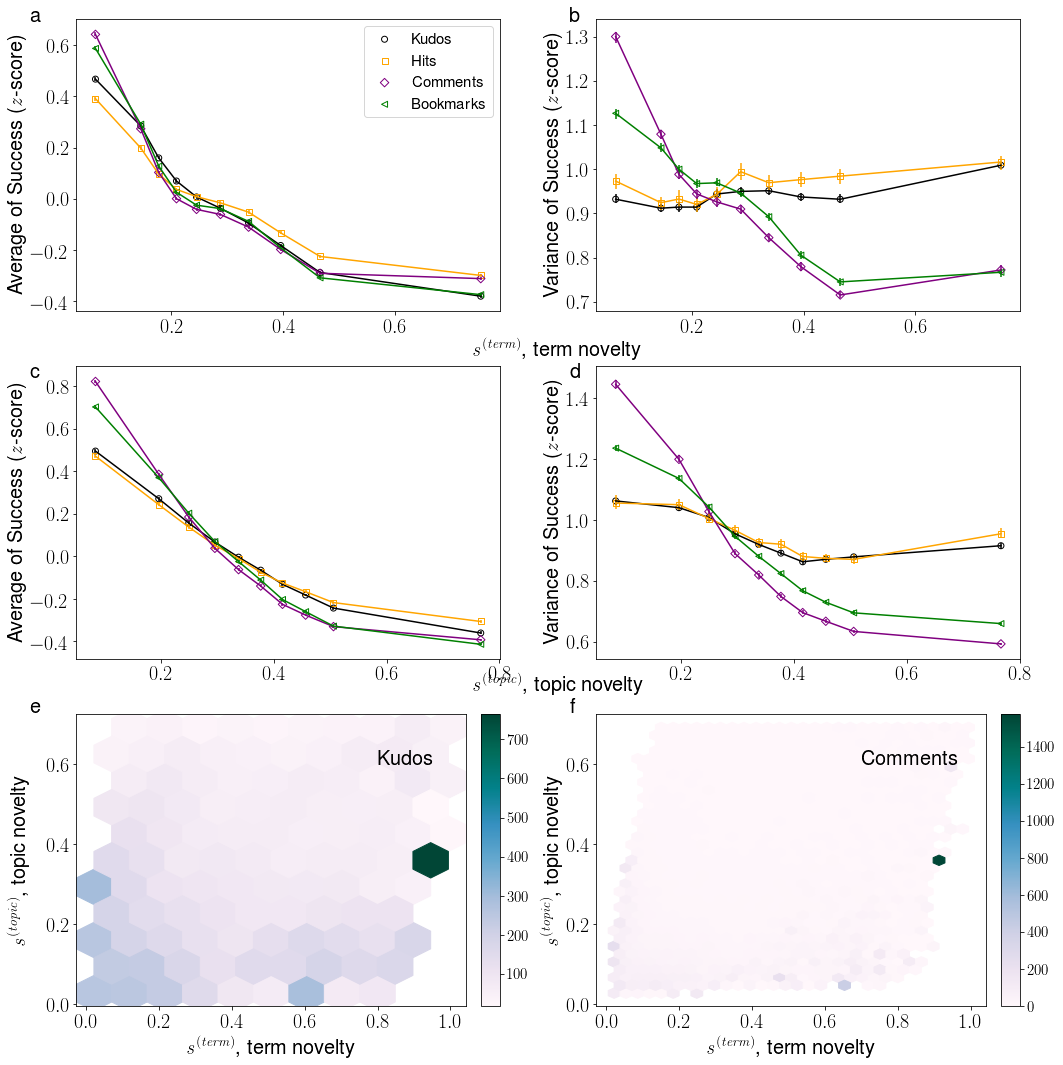

In [31]:
fig, axes = plt.subplots(3,2,figsize = (15,15))
# fig.subplots_adjust(bottom = 0.4)


x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
axes[0][0].errorbar(x, y, yerr=err, color='black')
axes[0][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_ave)
axes[0][0].errorbar(x, y, yerr=err, c='orange')
axes[0][0].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_ave)
axes[0][0].errorbar(x, y, yerr=err, c='purple')
axes[0][0].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_ave)
axes[0][0].errorbar(x, y, yerr=err, c='green')
axes[0][0].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

axes[0][0].legend(prop={'size': 15})
axes[0][0].set_ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
axes[0][0].tick_params(labelsize=20)

x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
axes[0][1].errorbar(x, y, yerr=err, color='black')
axes[0][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_var)
axes[0][1].errorbar(x, y, yerr=err, c='orange')
axes[0][1].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_var)
axes[0][1].errorbar(x, y, yerr=err, c='purple')
axes[0][1].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_var)
axes[0][1].errorbar(x, y, yerr=err, c='green')
axes[0][1].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
axes[0][1].set_ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
# plt.legend()
axes[0][1].tick_params(labelsize=20)


x, y, err = extract_plot_vals(lda_kudos_dict_ave)
axes[1][0].errorbar(x, y, yerr=err, color='black')
axes[1][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(lda_hits_dict_ave)
axes[1][0].errorbar(x, y, yerr=err, c='orange')
axes[1][0].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_ave)
axes[1][0].errorbar(x, y, yerr=err, c='purple')
axes[1][0].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_ave)
axes[1][0].errorbar(x, y, yerr=err, c='green')
axes[1][0].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

# plt.legend(prop={'size': 15})
axes[1][0].set_ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
axes[1][0].tick_params(labelsize=20)


x, y, err = extract_plot_vals(lda_kudos_dict_var)
axes[1][1].errorbar(x, y, yerr=err, color='black')
axes[1][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(lda_hits_dict_var)
axes[1][1].errorbar(x, y, yerr=err, c='orange')
axes[1][1].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_var)
axes[1][1].errorbar(x, y, yerr=err, c='purple')
axes[1][1].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_var)
axes[1][1].errorbar(x, y, yerr=err, c='green')
axes[1][1].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
axes[1][1].set_ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
axes[1][1].tick_params(labelsize=20)
# plt.legend(prop={'size': 15})
# plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
# plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)

fig.text(0.45, 0.66, '$\it{s}^{(term)}$, term novelty',fontsize=20)
fig.text(0.45, 0.35, '$\it{s}^{(topic)}$, topic novelty',fontsize=20)
fig.text(0.04, 0.97, 'a',fontsize=20)
fig.text(0.54, 0.97, 'b',fontsize=20)
fig.text(0.04, 0.64, 'c',fontsize=20)
fig.text(0.54, 0.64, 'd',fontsize=20)
fig.text(0.04, 0.33, 'e',fontsize=20)
fig.text(0.54, 0.33, 'f',fontsize=20)

h1 = axes[2][0].hexbin(df_all['Cos'], df_all['JSD'], C=df_all['Kudos'], reduce_C_function=np.mean, gridsize=10, cmap='PuBuGn')
axes[2][0].set_xlabel('$\it{s}^{(term)}$, term novelty', fontsize=20)
axes[2][0].set_ylabel('$\it{s}^{(topic)}$, topic novelty', fontsize=20)
axes[2][0].yaxis.set_label_coords(-0.12, 0.5)
axes[2][0].tick_params(labelsize=20)
divider = make_axes_locatable(axes[2][0])
cax1 = divider.append_axes("right",size="5%",pad=0.2)
cbar1 = axes[2][0].figure.colorbar(h1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
axes[2][0].text(0.8, 0.6, 'Kudos', fontsize=20)


h2 = axes[2][1].hexbin(df_all['Cos'], df_all['JSD'], C=df_all['Comments'],  reduce_C_function=np.mean, gridsize=30, cmap='PuBuGn')
axes[2][1].set_xlabel('$\it{s}^{(term)}$, term novelty', fontsize=20)
axes[2][1].set_ylabel('$\it{s}^{(topic)}$, topic novelty', fontsize=20)
axes[2][1].tick_params(labelsize=20)
axes[2][1].text(0.7, 0.6, 'Comments', fontsize=20)
divider = make_axes_locatable(axes[2][1])
cax2 = divider.append_axes("right",size="5%",pad=0.2)
cbar2 = fig.colorbar(h2, cax=cax2)
cbar2.ax.tick_params(labelsize=15)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.tight_layout()
# plt.savefig('scatter_var_ave_merged_heatmap.pdf', type='pdf', bbox_inches='tight')


In [ ]:
# fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]
# for i,fandom in enumerate(fandom_list):
#     df = pd.read_csv(os.path.join(lda_path,fandom), sep = '\t')
#     plt.figure()
#     plt.hist(df.JSD.tolist())
# #     plt.title(str(fandom))

In [ ]:
# lda_path_2 = '../../data/lda_merged_chs_202001/'
# fandom_list = [i for i in os.listdir(lda_path_2) if 'tsv' in i]
# for i,fandom in enumerate(fandom_list):
#     df = pd.read_csv(os.path.join(lda_path_2,fandom), sep = '\t')
#     plt.figure()
#     plt.hist(df.JSD.tolist())
# #     plt.title(str(fandom))